In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.odr import ODR, Model, RealData

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)

from src.utils.constants import *
from src.utils.CosmoFunc import *
from src.utils.functions import density_contour

def bin_data(x: np.array, y: np.array, n_bin: int, window_size: float):
    # x_bin = np.linspace(np.min(x), np.max(x), n_bin)
    x_bin = np.linspace(0.00475, 0.05377, n_bin)

    x_bin_ = []
    y_bin = []
    y_bin_err = []
    y_bin_stderr = []

    for x_trial in x_bin:
        x_lower = x_trial - window_size
        x_upper = x_trial + window_size

        y_ = y[(x >= x_lower) & (x <= x_upper)]

        if len(y_):
            x_bin_.append(x_trial)
            y_bin.append(np.median(y_))
            y_bin_err.append(np.std(y_))
            y_bin_stderr.append(np.std(y_) / np.sqrt(len(y_)))
        else:
            continue

    return x_bin_, y_bin, y_bin_err, y_bin_stderr

# 6dFGS comparison

Text(0, 0.5, '$\\eta_\\mathrm{CF4}$')

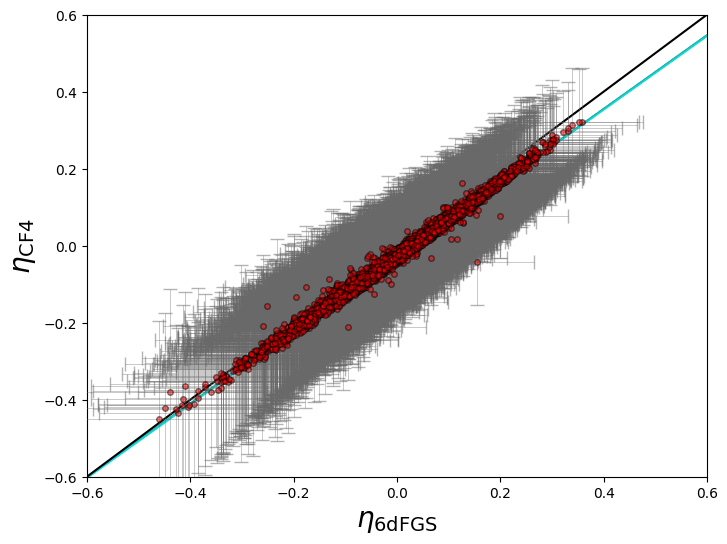

In [63]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

# My measurements
df_mine = pd.read_csv('../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/6dfgs.csv')
df_mine = df_mine[['tmass', '_6dFGS', 'logdist_all_combined', 'logdist_err_all_combined']]

# CF4 values
df_cf4 = pd.read_csv('../../data/external/logdist/CF4_6dF.csv')
df_cf4 = df_cf4[['Name', 'DzDh', 'eDz', 'Vcmb']]

df = df_mine.merge(df_cf4, left_on='_6dFGS', right_on='Name')

ndata = len(df)
x = df[f"logdist_all_combined"].to_numpy()
xerr = df[f"logdist_err_all_combined"].to_numpy()
y = df['DzDh'].to_numpy()
yerr = df['eDz'].to_numpy()

# ODR stuff
linear = Model(f)
mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
myoutput = myodr.run()
# myoutput.pprint()
m_pred, b_pred = myoutput.beta

# Create MC sample
n_trial = 10000
m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

left_lim = -0.6
right_lim = 0.6
x_trial = np.linspace(left_lim, right_lim, 1000)
y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
y_pred = m_pred * x_trial + b_pred
y_lower = np.quantile(y_trial, q=0.16, axis=0)
y_upper = np.quantile(y_trial, q=0.84, axis=0)

fig, ax = plt.subplots(figsize=(8, 6))

# Actual data + error bars
ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

# Prediction + confidence intervals
ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

# 1-to-1 line
ax.plot([left_lim, right_lim], [left_lim, right_lim], c='k')

ax.set_xlim(left_lim, right_lim)
ax.set_ylim(left_lim, right_lim)
ax.set_xlabel(r"$\eta_\mathrm{survey}$".replace("survey", '6dFGS'), fontsize=20)
ax.set_ylabel(r"$\eta_\mathrm{survey}$".replace("survey", 'CF4'), fontsize=20)

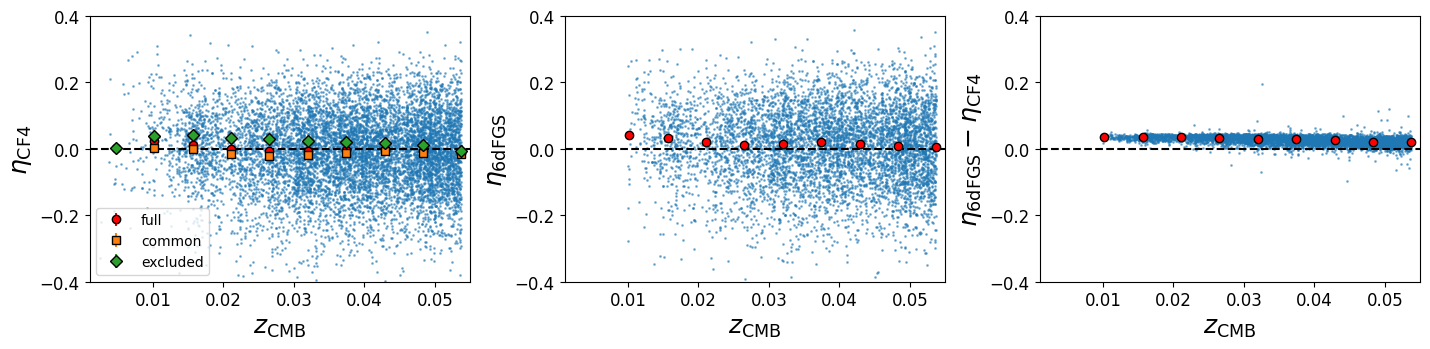

In [9]:
a_ = 1.8
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8 * a_, 2 * a_))
N_BIN = 10
WINDOW_SIZE = 0.005
ylabels = ['$\eta_\mathrm{CF4}$', '$\eta_\mathrm{6dFGS}$', '$\eta_\mathrm{6dFGS} - \eta_\mathrm{CF4}$']

# Load my 6dFGS data
df_mine = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/6dfgs.csv")
df_mine["Name"] = df_mine["_6dFGS"]

# Load CF4 6dFGS data
df_cf4 = pd.read_csv("../../data/external/logdist/CF4_6dF.csv")
df_cf4['logdist_corr'] = df_cf4['DzDh']
df_cf4['zcmb_group'] = df_cf4['Vgp'] / LightSpeed

# Plot Cullan's data vs redshift
## Full redshift-limited sample
ax1.scatter(df_cf4['zcmb_group'], df_cf4['logdist_corr'], s=1, alpha=0.5)
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_cf4['zcmb_group'].to_numpy(), df_cf4['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k', label='full')

## Galaxies in common with mine
df_common = df_mine[['Name', 'z_dist_est', 'logdist_all_combined', 'logdist_err_all_combined']]\
    .merge(df_cf4[['Name', 'zcmb_group', 'logdist_corr']], how='inner')
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_common['zcmb_group'].to_numpy(), df_common['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
# ax1.scatter(df_common['zcmb_group'], df_common['logdist_corr'], s=1, alpha=0.5)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='s', c='C1', mec='k', label='common')

## Galaxies excluded from mine
df_excluded = df_cf4[~(df_cf4['Name'].isin(df_common['Name'].tolist()))]
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_excluded['zcmb_group'].to_numpy(), df_excluded['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
# ax1.scatter(df_excluded['zcmb_group'], df_excluded['logdist_corr'], s=1, alpha=0.5)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='D', c='C2', mec='k', label='excluded')
ax1.legend()


# Plot my logdist vs redshift
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_mine['z_dist_est'].to_numpy(), df_mine['logdist_all_combined'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax2.scatter(df_mine['z_dist_est'], df_mine['logdist_all_combined'], s=1, alpha=0.5)
ax2.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k')


# Plot logdist difference vs redshift
df_common['delta_logdist'] = df_common['logdist_all_combined'] - df_common['logdist_corr']
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_common['z_dist_est'].to_numpy(), df_common['delta_logdist'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax3.scatter(df_common['z_dist_est'], df_common['delta_logdist'], s=1, alpha=0.5)
ax3.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k')


for i, ax in enumerate(fig.axes):
    ax.axhline(y=0, c='k', ls='--')
    ax.set_xlim(0.001, 0.055)
    ax.set_ylim(-0.4, 0.4)
    ax.set_ylabel(ylabel=ylabels[i], fontsize=18)
    ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
    ax.tick_params(axis='both', which='both', labelsize=12, direction="out")

fig.tight_layout()
fig.savefig('./6dfgs_comparison.pdf', bbox_inches='tight', dpi=300)

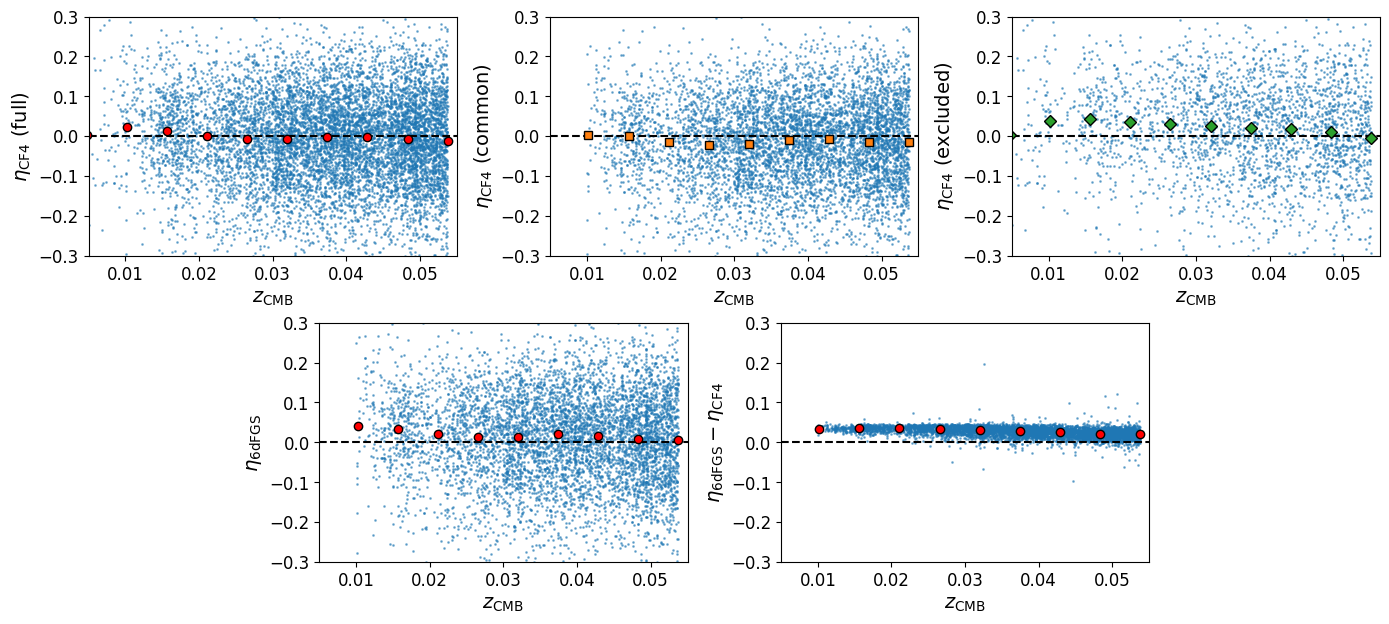

In [67]:
# Create a figure
fig = plt.figure(figsize=(14, 18))

# Create a GridSpec with 3 rows and 3 columns
gs = gridspec.GridSpec(6, 6, figure=fig)

ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])

ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])

a_ = 1.8
N_BIN = 10
WINDOW_SIZE = 0.005
ylabels = ['$\eta_\mathrm{CF4}$ (full)', '$\eta_\mathrm{CF4}$ (common)', '$\eta_\mathrm{CF4}$ (excluded)', '$\eta_\mathrm{6dFGS}$', '$\eta_\mathrm{6dFGS} - \eta_\mathrm{CF4}$']

# Load my 6dFGS data
df_mine = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/6dfgs.csv")
df_mine["Name"] = df_mine["_6dFGS"]

# Load CF4 6dFGS data
df_cf4 = pd.read_csv("../../data/external/logdist/CF4_6dF.csv")
df_cf4['logdist_corr'] = df_cf4['DzDh']
df_cf4['zcmb_group'] = df_cf4['Vgp'] / LightSpeed

# Plot Cullan's data vs redshift
## Full redshift-limited sample
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_cf4['zcmb_group'].to_numpy(), df_cf4['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax1.scatter(df_cf4['zcmb_group'], df_cf4['logdist_corr'], s=1, alpha=0.5)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k', label='full')

## Galaxies in common with mine
df_common = df_mine[['Name', 'z_dist_est', 'logdist_all_combined', 'logdist_err_all_combined']]\
    .merge(df_cf4[['Name', 'zcmb_group', 'logdist_corr']], how='inner')
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_common['zcmb_group'].to_numpy(), df_common['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax2.scatter(df_common['zcmb_group'], df_common['logdist_corr'], s=1, alpha=0.5)
ax2.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='s', c='C1', mec='k', label='common')

## Galaxies excluded from mine
df_excluded = df_cf4[~(df_cf4['Name'].isin(df_common['Name'].tolist()))]
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_excluded['zcmb_group'].to_numpy(), df_excluded['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax3.scatter(df_excluded['zcmb_group'], df_excluded['logdist_corr'], s=1, alpha=0.5)
ax3.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='D', c='C2', mec='k', label='excluded')


# Plot my logdist vs redshift
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_mine['z_dist_est'].to_numpy(), df_mine['logdist_all_combined'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax4.scatter(df_mine['z_dist_est'], df_mine['logdist_all_combined'], s=1, alpha=0.5)
ax4.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k')


# Plot logdist difference vs redshift
df_common['delta_logdist'] = df_common['logdist_all_combined'] - df_common['logdist_corr']
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_common['z_dist_est'].to_numpy(), df_common['delta_logdist'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax5.scatter(df_common['z_dist_est'], df_common['delta_logdist'], s=1, alpha=0.5)
ax5.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k')


for i, ax in enumerate(fig.axes):
    ax.axhline(y=0, c='k', ls='--')
    ax.set_xlim(0.005, 0.055)
    ax.set_ylim(-0.3, 0.3)
    ax.set_ylabel(ylabel=ylabels[i], fontsize=14)
    ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=14)
    ax.tick_params(axis='both', which='both', labelsize=12, direction="out")

fig.tight_layout()

# 6dFGS vs CF4 using 6dFGS FP fit

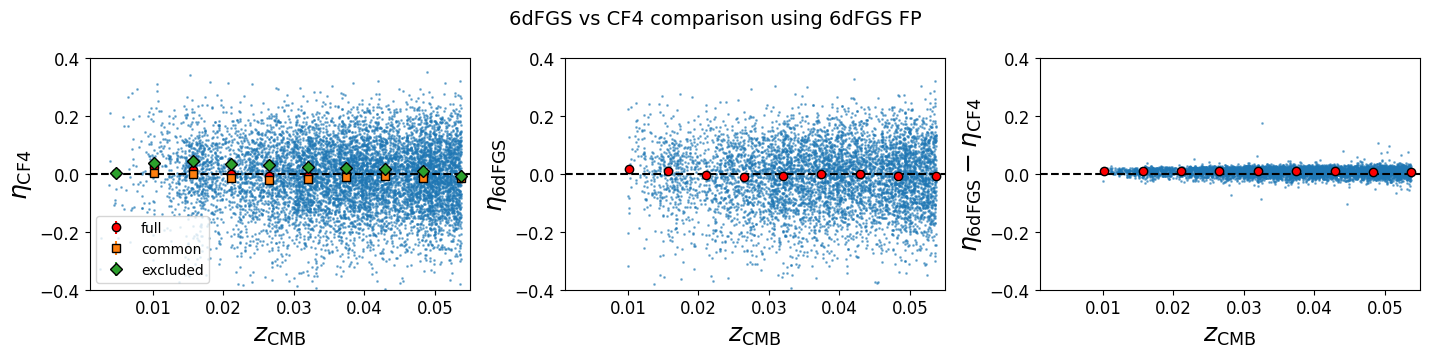

In [11]:
a_ = 1.8
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8 * a_, 2 * a_))
N_BIN = 10
WINDOW_SIZE = 0.005
ylabels = ['$\eta_\mathrm{CF4}$', '$\eta_\mathrm{6dFGS}$', '$\eta_\mathrm{6dFGS} - \eta_\mathrm{CF4}$']

# Load my 6dFGS data
df_mine = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/6dfgs.csv")
df_mine["Name"] = df_mine["_6dFGS"]

# Load CF4 6dFGS data
df_cf4 = pd.read_csv("../../data/external/logdist/CF4_6dF.csv")
df_cf4['logdist_corr'] = df_cf4['DzDh']
df_cf4['zcmb_group'] = df_cf4['Vgp'] / LightSpeed

# Plot Cullan's data vs redshift
## Full redshift-limited sample
ax1.scatter(df_cf4['zcmb_group'], df_cf4['logdist_corr'], s=1, alpha=0.5)
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_cf4['zcmb_group'].to_numpy(), df_cf4['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k', label='full')

## Galaxies in common with mine
df_common = df_mine[['Name', 'z_dist_est', 'logdist_6dfgs', 'logdist_err_6dfgs']]\
    .merge(df_cf4[['Name', 'zcmb_group', 'logdist_corr']], how='inner')
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_common['zcmb_group'].to_numpy(), df_common['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
# ax1.scatter(df_common['zcmb_group'], df_common['logdist_corr'], s=1, alpha=0.5)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='s', c='C1', mec='k', label='common')

## Galaxies excluded from mine
df_excluded = df_cf4[~(df_cf4['Name'].isin(df_common['Name'].tolist()))]
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_excluded['zcmb_group'].to_numpy(), df_excluded['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
# ax1.scatter(df_excluded['zcmb_group'], df_excluded['logdist_corr'], s=1, alpha=0.5)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='D', c='C2', mec='k', label='excluded')
ax1.legend()


# Plot my logdist vs redshift
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_mine['z_dist_est'].to_numpy(), df_mine['logdist_6dfgs'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax2.scatter(df_mine['z_dist_est'], df_mine['logdist_6dfgs'], s=1, alpha=0.5)
ax2.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k')


# Plot logdist difference vs redshift
df_common['delta_logdist'] = df_common['logdist_6dfgs'] - df_common['logdist_corr']
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_common['z_dist_est'].to_numpy(), df_common['delta_logdist'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax3.scatter(df_common['z_dist_est'], df_common['delta_logdist'], s=1, alpha=0.5)
ax3.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k')


for i, ax in enumerate(fig.axes):
    ax.axhline(y=0, c='k', ls='--')
    ax.set_xlim(0.001, 0.055)
    ax.set_ylim(-0.4, 0.4)
    ax.set_ylabel(ylabel=ylabels[i], fontsize=18)
    ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
    ax.tick_params(axis='both', which='both', labelsize=12, direction="out")

fig.suptitle("6dFGS vs CF4 comparison using 6dFGS FP", fontsize=14)
fig.tight_layout()
fig.savefig('./6dfgs_comparison_6df_fp.png', bbox_inches='tight', dpi=300)

In [56]:
df_cf4['logdist']

,PGC,rej,1PGC,Nest,Name,Vcmb,Vgp,D75,D100,feD,DzDh,eDz,skew,RA,DE,Vg,Gp
0,27,1,27,0,g0000235-065610,10920,10920,145.5,109.2,0.27,0.015698,0.105029,-0.021398,0.0978,-6.9362,10920,-1
1,40,1,40,209793,g0000356-014547,6956,6956,116.4,87.3,0.31,-0.088660,0.118089,0.016330,0.1485,-1.7632,6956,-1
2,51,1,142,201987,g0000358-403432,14746,14746,248.6,186.5,0.42,-0.081111,0.152326,0.015862,0.1489,-40.5756,14746,-1
3,64,0,72642,200033,g0000523-355037,15324,14646,222.3,166.7,0.29,-0.034659,0.110224,0.010894,0.2181,-35.8437,14646,1261
4,66,0,72642,200033,g0000532-355911,14725,14646,191.0,143.2,0.27,0.030506,0.103811,-0.028422,0.2216,-35.9863,14646,1261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8880,4684754,0,4684754,210660,g0944459-715759,6624,6624,78.0,58.5,0.29,0.063476,0.111263,-0.023519,146.1912,-71.9665,6624,-1
8881,4684803,0,4684803,208156,g1937242-174502,9189,9189,153.4,115.1,0.27,-0.084619,0.102455,0.033847,294.3507,-17.7505,9189,-1
8882,4684804,0,4684804,208117,g1934263-174833,9163,9163,89.0,66.8,0.32,0.150652,0.121477,-0.057482,293.6096,-17.8093,9163,-1
8883,4684828,0,4684828,0,g1939071-155316,15569,15569,247.6,185.7,0.31,-0.054598,0.116297,0.030770,294.7795,-15.8876,15569,-1


# SDSS Comparison

Text(0, 0.5, '$\\eta_\\mathrm{H22}$')

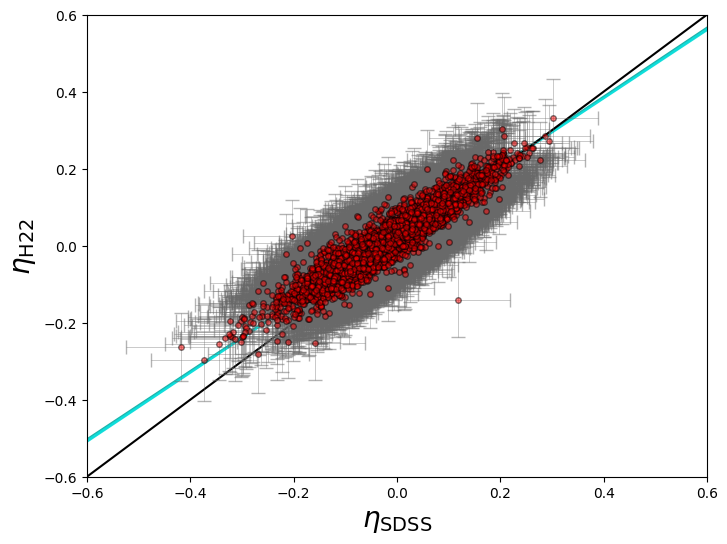

In [8]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

# My measurements
df_mine = pd.read_csv('../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/sdss.csv')
df_mine = df_mine[['tmass', 'objid', 'logdist_all_combined', 'logdist_err_all_combined', 'z_dist_est']]

# H22 values
df_h22 = pd.read_csv('../../data/external/logdist/cullan_logdist.csv')
df_h22['objid'] = df_h22['objid'].apply(lambda x: 'SDSS' + str(x))
df_h22 = df_h22[['objid', 'logdist_corr', 'logdist_corr_err', 'zcmb_group']]

df = df_mine.merge(df_h22, on='objid')

ndata = len(df)
x = df[f"logdist_all_combined"].to_numpy()
xerr = df[f"logdist_err_all_combined"].to_numpy()
y = df['logdist_corr'].to_numpy()
yerr = df['logdist_corr_err'].to_numpy()

# ODR stuff
linear = Model(f)
mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
myoutput = myodr.run()
# myoutput.pprint()
m_pred, b_pred = myoutput.beta

# Create MC sample
n_trial = 10000
m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

left_lim = -0.6
right_lim = 0.6
x_trial = np.linspace(left_lim, right_lim, 1000)
y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
y_pred = m_pred * x_trial + b_pred
y_lower = np.quantile(y_trial, q=0.16, axis=0)
y_upper = np.quantile(y_trial, q=0.84, axis=0)

fig, ax = plt.subplots(figsize=(8, 6))

# Actual data + error bars
ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

# Prediction + confidence intervals
ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

# 1-to-1 line
ax.plot([left_lim, right_lim], [left_lim, right_lim], c='k')

ax.set_xlim(left_lim, right_lim)
ax.set_ylim(left_lim, right_lim)
ax.set_xlabel(r"$\eta_\mathrm{survey}$".replace("survey", 'SDSS'), fontsize=20)
ax.set_ylabel(r"$\eta_\mathrm{survey}$".replace("survey", 'H22'), fontsize=20)

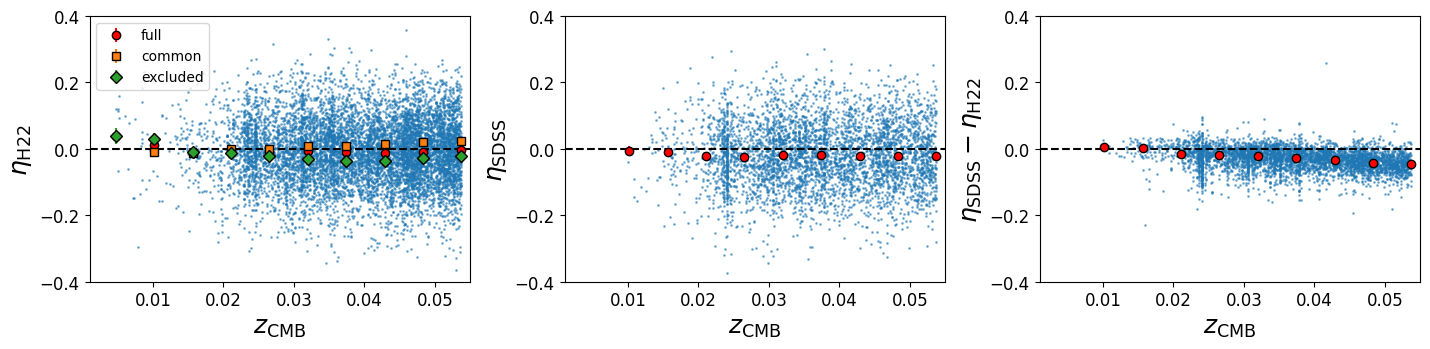

In [12]:
a_ = 1.8
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8 * a_, 2 * a_))
N_BIN = 10
WINDOW_SIZE = 0.005
ylabels = ['$\eta_\mathrm{H22}$', '$\eta_\mathrm{SDSS}$', '$\eta_\mathrm{SDSS} - \eta_\mathrm{H22}$']

# Load my SDSS data
df_mine = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/sdss.csv")

# Load Cullan's SDSS data
df_cullan = pd.read_csv("../../data/external/logdist/cullan_logdist.csv")
df_cullan['objid'] = df_cullan['objid'].apply(lambda x: "SDSS" + str(x))
df_cullan = df_cullan[df_cullan['zcmb_group'] <= ZMAX]

# Plot Cullan's data vs redshift
## Full redshift-limited sample
ax1.scatter(df_cullan['zcmb_group'], df_cullan['logdist_corr'], s=1, alpha=0.5)
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_cullan['zcmb_group'].to_numpy(), df_cullan['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k', label='full')

## Galaxies in common with mine
df_common = df_mine[['objid', 'z_dist_est', 'logdist_all_combined', 'logdist_err_all_combined']]\
    .merge(df_cullan[['objid', 'zcmb_group', 'logdist_corr', 'logdist_corr_err']], how='inner')
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_common['zcmb_group'].to_numpy(), df_common['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
# ax1.scatter(df_common['zcmb_group'], df_common['logdist_corr'], s=1, alpha=0.5)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='s', c='C1', mec='k', label='common')

## Galaxies excluded from mine
df_excluded = df_cullan[~(df_cullan['objid'].isin(df_common['objid'].tolist()))]
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_excluded['zcmb_group'].to_numpy(), df_excluded['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
# ax1.scatter(df_excluded['zcmb_group'], df_excluded['logdist_corr'], s=1, alpha=0.5)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='D', c='C2', mec='k', label='excluded')
ax1.legend()


# Plot my logdist vs redshift
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_mine['z_dist_est'].to_numpy(), df_mine['logdist_all_combined'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax2.scatter(df_mine['z_dist_est'], df_mine['logdist_all_combined'], s=1, alpha=0.5)
ax2.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k')


# Plot logdist difference vs redshift
df_common['delta_logdist'] = df_common['logdist_all_combined'] - df_common['logdist_corr']
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_common['z_dist_est'].to_numpy(), df_common['delta_logdist'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax3.scatter(df_common['z_dist_est'], df_common['delta_logdist'], s=1, alpha=0.5)
ax3.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k')


for i, ax in enumerate(fig.axes):
    ax.axhline(y=0, c='k', ls='--')
    ax.set_xlim(0.001, 0.055)
    ax.set_ylim(-0.4, 0.4)
    ax.set_ylabel(ylabel=ylabels[i], fontsize=18)
    ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
    ax.tick_params(axis='both', which='both', labelsize=12, direction="out")

fig.tight_layout()
fig.savefig('./sdss_comparison.pdf', bbox_inches='tight', dpi=300)

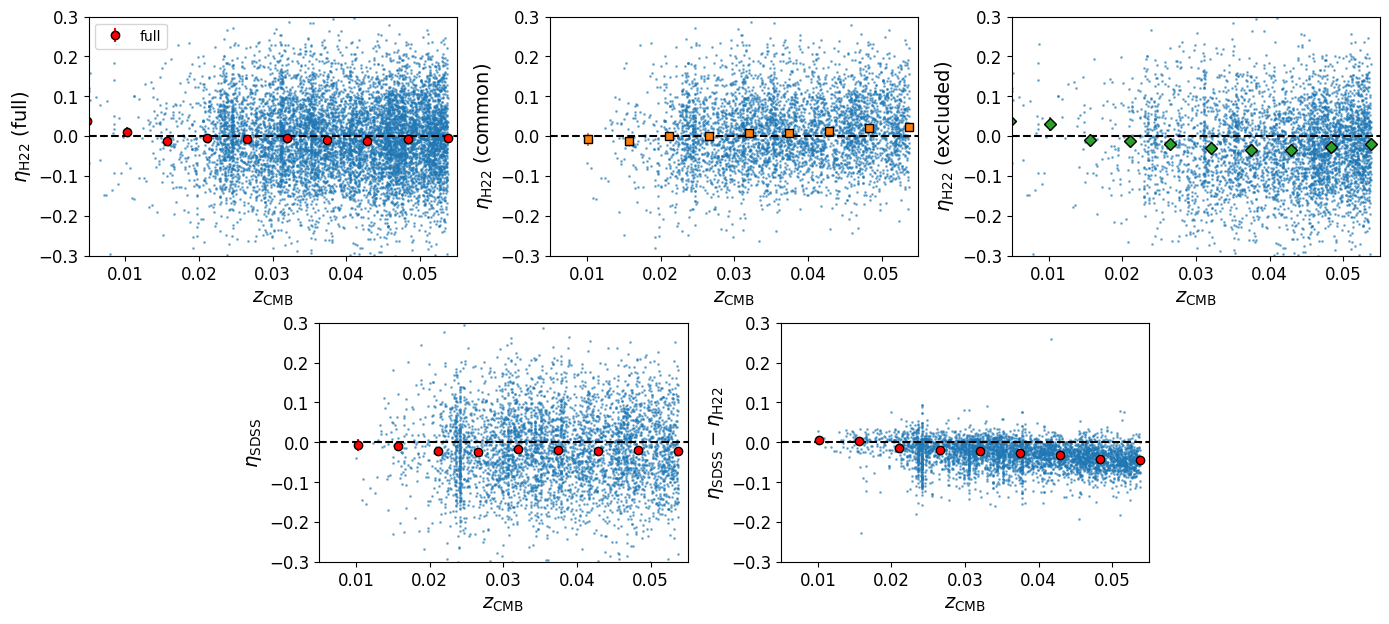

In [54]:
# Create a figure
fig = plt.figure(figsize=(14, 18))

# Create a GridSpec with 3 rows and 3 columns
gs = gridspec.GridSpec(6, 6, figure=fig)

ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])

ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])

a_ = 1.8
N_BIN = 10
WINDOW_SIZE = 0.005
ylabels = ['$\eta_\mathrm{H22}$ (full)', '$\eta_\mathrm{H22}$ (common)', '$\eta_\mathrm{H22}$ (excluded)', '$\eta_\mathrm{SDSS}$', '$\eta_\mathrm{SDSS} - \eta_\mathrm{H22}$']

# Load my SDSS data
df_mine = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/sdss.csv")

# Load Cullan's SDSS data
df_cullan = pd.read_csv("../../data/external/logdist/cullan_logdist.csv")
df_cullan['objid'] = df_cullan['objid'].apply(lambda x: "SDSS" + str(x))
df_cullan = df_cullan[df_cullan['zcmb_group'] <= ZMAX]

# Plot Cullan's data vs redshift
## Full redshift-limited sample
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_cullan['zcmb_group'].to_numpy(), df_cullan['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax1.scatter(df_cullan['zcmb_group'], df_cullan['logdist_corr'], s=1, alpha=0.5)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k', label='full')

## Galaxies in common with mine
df_common = df_mine[['objid', 'z_dist_est', 'logdist_all_combined', 'logdist_err_all_combined']]\
    .merge(df_cullan[['objid', 'zcmb_group', 'logdist_corr', 'logdist_corr_err']], how='inner')
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_common['zcmb_group'].to_numpy(), df_common['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax2.scatter(df_common['zcmb_group'], df_common['logdist_corr'], s=1, alpha=0.5)
ax2.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='s', c='C1', mec='k', label='common')

## Galaxies excluded from mine
df_excluded = df_cullan[~(df_cullan['objid'].isin(df_common['objid'].tolist()))]
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_excluded['zcmb_group'].to_numpy(), df_excluded['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax3.scatter(df_excluded['zcmb_group'], df_excluded['logdist_corr'], s=1, alpha=0.5)
ax3.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='D', c='C2', mec='k', label='excluded')
ax1.legend()


# Plot my logdist vs redshift
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_mine['z_dist_est'].to_numpy(), df_mine['logdist_all_combined'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax4.scatter(df_mine['z_dist_est'], df_mine['logdist_all_combined'], s=1, alpha=0.5)
ax4.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k')


# Plot logdist difference vs redshift
df_common['delta_logdist'] = df_common['logdist_all_combined'] - df_common['logdist_corr']
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_common['z_dist_est'].to_numpy(), df_common['delta_logdist'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax5.scatter(df_common['z_dist_est'], df_common['delta_logdist'], s=1, alpha=0.5)
ax5.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k')


for i, ax in enumerate(fig.axes):
    ax.axhline(y=0, c='k', ls='--')
    ax.set_xlim(0.005, 0.055)
    ax.set_ylim(-0.3, 0.3)
    ax.set_ylabel(ylabel=ylabels[i], fontsize=14)
    ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=14)
    ax.tick_params(axis='both', which='both', labelsize=12, direction="out")

fig.tight_layout()

# SDSS vs H22 using SDSS FP

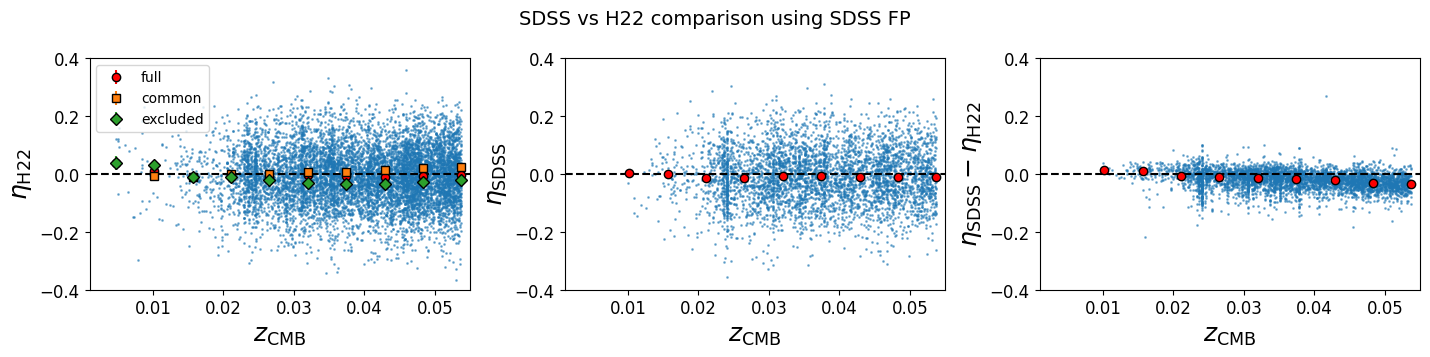

In [12]:
a_ = 1.8
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8 * a_, 2 * a_))
N_BIN = 10
WINDOW_SIZE = 0.005
ylabels = ['$\eta_\mathrm{H22}$', '$\eta_\mathrm{SDSS}$', '$\eta_\mathrm{SDSS} - \eta_\mathrm{H22}$']

# Load my SDSS data
df_mine = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/sdss.csv")

# Load Cullan's SDSS data
df_cullan = pd.read_csv("../../data/external/logdist/cullan_logdist.csv")
df_cullan['objid'] = df_cullan['objid'].apply(lambda x: "SDSS" + str(x))
df_cullan = df_cullan[df_cullan['zcmb_group'] <= ZMAX]

# Plot Cullan's data vs redshift
## Full redshift-limited sample
ax1.scatter(df_cullan['zcmb_group'], df_cullan['logdist_corr'], s=1, alpha=0.5)
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_cullan['zcmb_group'].to_numpy(), df_cullan['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k', label='full')

## Galaxies in common with mine
df_common = df_mine[['objid', 'z_dist_est', 'logdist_sdss', 'logdist_err_sdss']]\
    .merge(df_cullan[['objid', 'zcmb_group', 'logdist_corr', 'logdist_corr_err']], how='inner')
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_common['zcmb_group'].to_numpy(), df_common['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
# ax1.scatter(df_common['zcmb_group'], df_common['logdist_corr'], s=1, alpha=0.5)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='s', c='C1', mec='k', label='common')

## Galaxies excluded from mine
df_excluded = df_cullan[~(df_cullan['objid'].isin(df_common['objid'].tolist()))]
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_excluded['zcmb_group'].to_numpy(), df_excluded['logdist_corr'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
# ax1.scatter(df_excluded['zcmb_group'], df_excluded['logdist_corr'], s=1, alpha=0.5)
ax1.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='D', c='C2', mec='k', label='excluded')
ax1.legend()


# Plot my logdist vs redshift
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_mine['z_dist_est'].to_numpy(), df_mine['logdist_sdss'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax2.scatter(df_mine['z_dist_est'], df_mine['logdist_sdss'], s=1, alpha=0.5)
ax2.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k')


# Plot logdist difference vs redshift
df_common['delta_logdist'] = df_common['logdist_sdss'] - df_common['logdist_corr']
z_bin, logdist_bin, logdist_bin_err, logdist_bin_stderr = bin_data(df_common['z_dist_est'].to_numpy(), df_common['delta_logdist'].to_numpy(), n_bin=N_BIN, window_size=WINDOW_SIZE)
ax3.scatter(df_common['z_dist_est'], df_common['delta_logdist'], s=1, alpha=0.5)
ax3.errorbar(z_bin, logdist_bin, yerr=logdist_bin_stderr, fmt='o', c='r', mec='k')


for i, ax in enumerate(fig.axes):
    ax.axhline(y=0, c='k', ls='--')
    ax.set_xlim(0.001, 0.055)
    ax.set_ylim(-0.4, 0.4)
    ax.set_ylabel(ylabel=ylabels[i], fontsize=18)
    ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
    ax.tick_params(axis='both', which='both', labelsize=12, direction="out")

fig.suptitle("SDSS vs H22 comparison using SDSS FP", fontsize=14)
fig.tight_layout()
fig.savefig('./sdss_comparison_sdss_fp.png', bbox_inches='tight', dpi=300)